### Plot signals

In [1]:
import sys
from pathlib import Path

# add parent folder to the path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path, module_path

(['/nfs/projects5/basecalling-jorge/basecalling/notebooks',
  '/home/javila/micromamba/envs/basecalling-cuda117/lib/python310.zip',
  '/home/javila/micromamba/envs/basecalling-cuda117/lib/python3.10',
  '/home/javila/micromamba/envs/basecalling-cuda117/lib/python3.10/lib-dynload',
  '',
  '/home/javila/micromamba/envs/basecalling-cuda117/lib/python3.10/site-packages',
  '/nfs/projects5/basecalling-jorge/basecalling'],
 '/nfs/projects5/basecalling-jorge/basecalling')

In [2]:
%matplotlib inline  

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from feito.dataloaders import DatasetONT, DatasetBasecalling

**Training Loader**

In [3]:
recfile = "/projects5/basecalling-jorge/basecalling/data/subsample_train.hdf5"
dataset = DatasetONT(recfile, output_network_len=501)

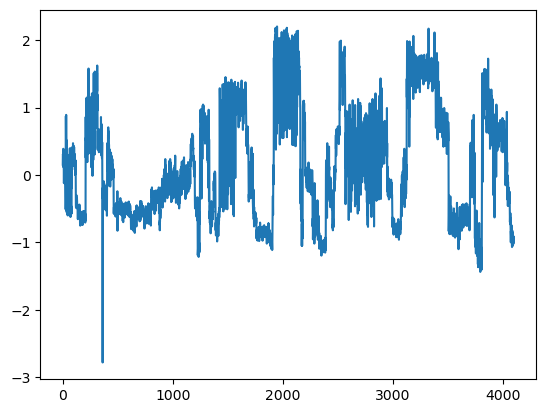

In [55]:
signal, *_ =dataset[0]
plt.plot(range(len(signal[0])), signal[0])

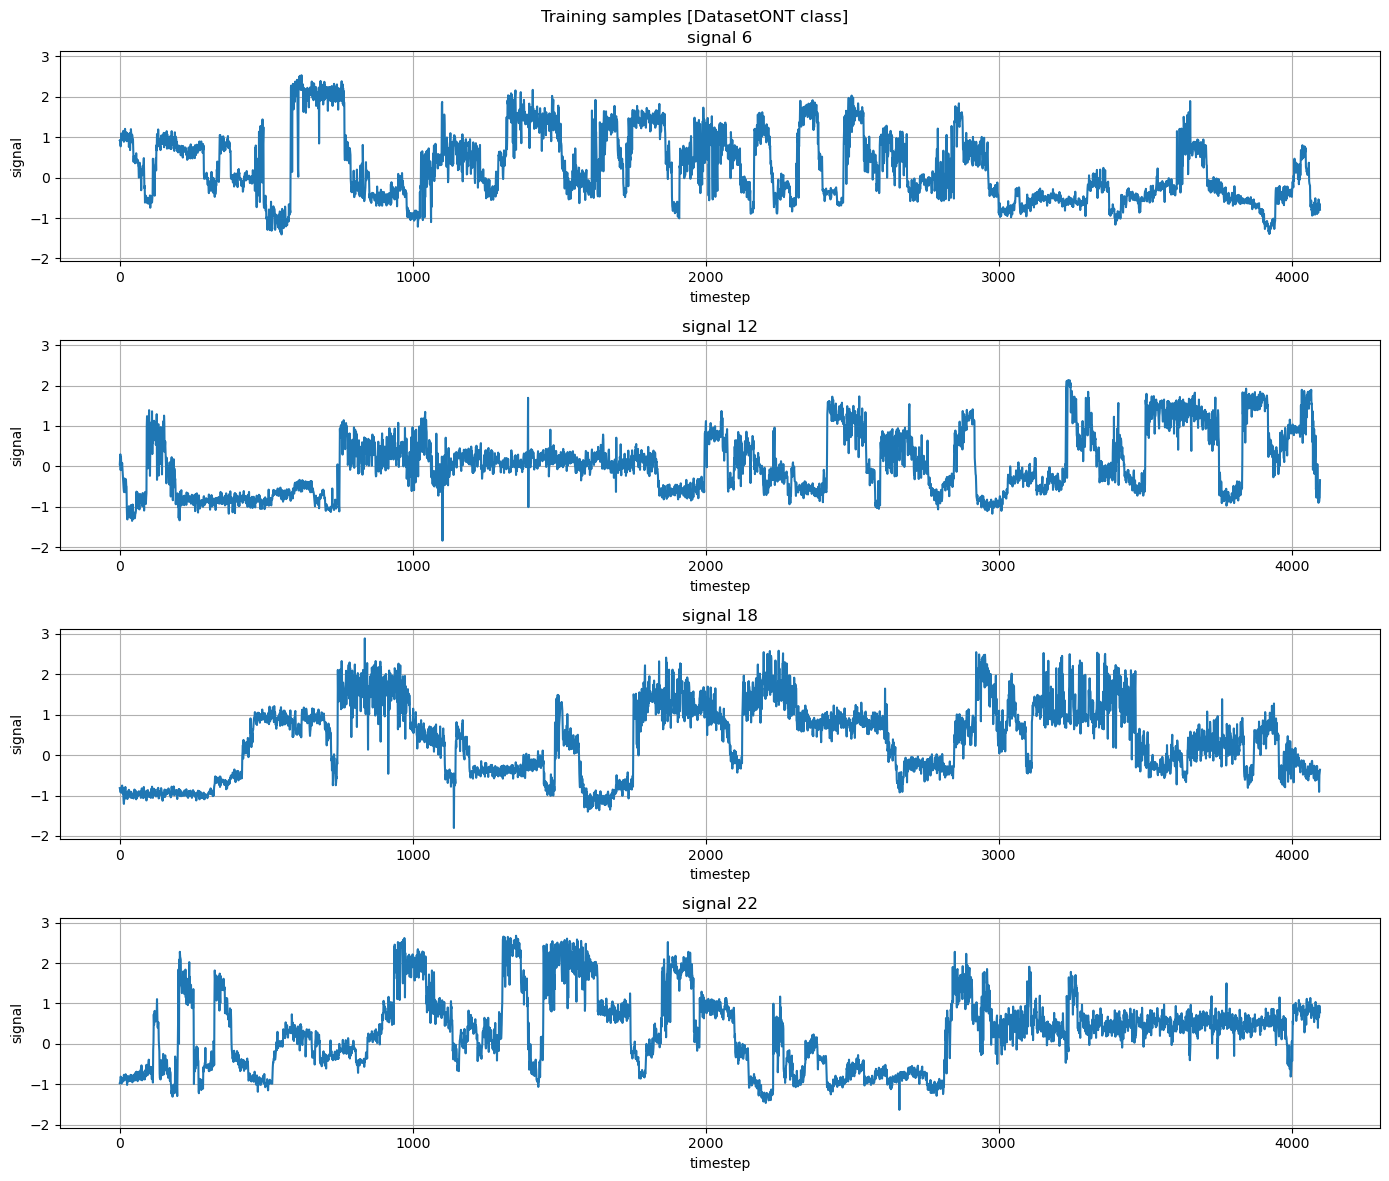

In [85]:
start_item = 6
idx_dataset= [6, 12 , 18 , 22] #range(start_item,start_item+n_signals,1)

nrows=len(idx_dataset)
fig, axs= plt.subplots(nrows, figsize=(14,12), sharex="row", sharey="col")

for i, ax in zip(idx_dataset, axs.flat):
    # get data from DatasetONT 
    signal, label, _,  _ = dataset[i]
    tsteps = range(len(signal[0]))
    
    # plot signal
    ax.plot(tsteps, signal[0])
    ax.set_title(f"signal {i}")
    ax.set_xlabel("timestep")
    ax.set_ylabel("signal")
    ax.grid(True)

fig.suptitle("Training samples [DatasetONT class]")    
fig.tight_layout()
plt.show()

**Basecaller Loader**

In [60]:
from feito.dataloaders import DatasetBasecalling

dataset_basecalling = DatasetBasecalling(
    ["../data/RODAN/test/mouse-dataset/0/0a0bf68b-3b64-4fc6-ba34-d853db589f4b.fast5",
     "../data/RODAN/test/mouse-dataset/0/0a8787dc-a4b9-45da-b4e0-8711ec36897e.fast5"
     ], path_save_index="compare-signals/index.csv")

Creatind Index for reads: 100%|██████████| 2/2 [00:00<00:00, 23.83it/s]


In [61]:
signal = dataset_basecalling[0]

In [64]:
signal[0]

tensor([-0.8231, -0.8631, -0.7259,  ..., -1.0803, -1.1375, -1.1318])

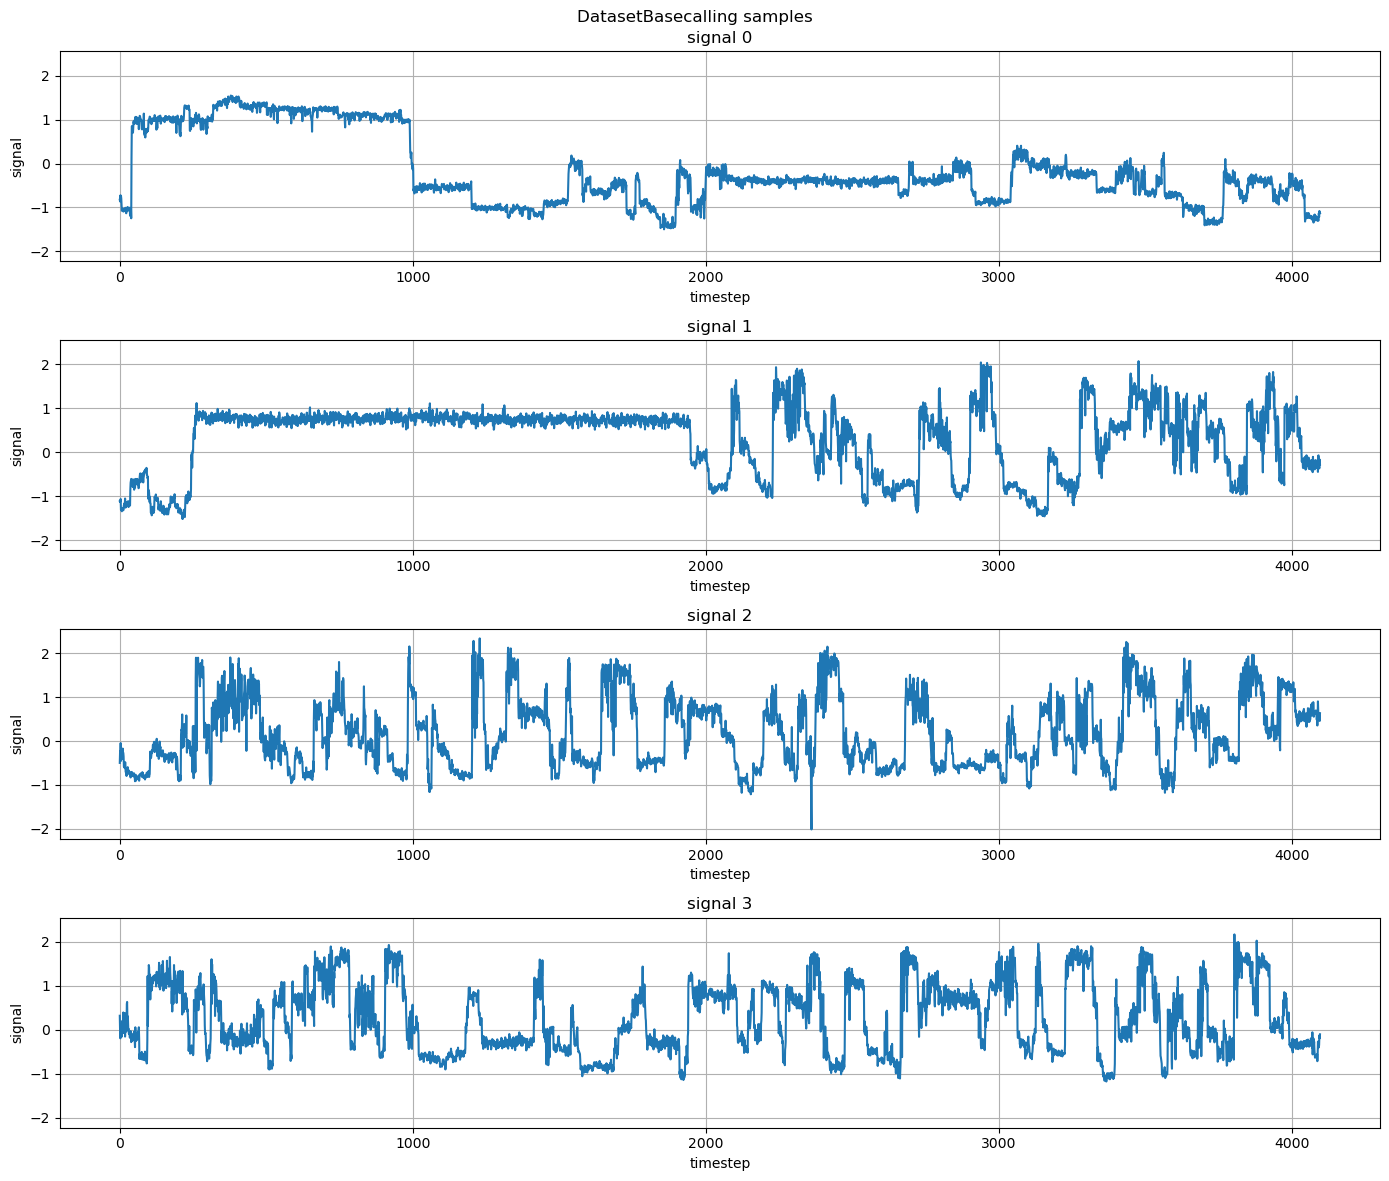

In [84]:
start_item = 0
n_signals=4
idx_dataset= range(start_item,start_item+n_signals,1) # [6, 12 , 18 , 22] 

nrows=len(idx_dataset)
fig_b, axs_b= plt.subplots(nrows, figsize=(14,12), sharex="row", sharey="col")

for i, ax in zip(idx_dataset, axs_b.flat):
    # get data from DatasetONT 
    signal = dataset_basecalling[i]
    tsteps = range(len(signal[0]))
    
    # plot signal
    ax.plot(tsteps, signal[0])
    ax.set_title(f"signal {i}")
    ax.set_xlabel("timestep")
    ax.set_ylabel("signal")
    ax.grid(True)

fig_b.suptitle("DatasetBasecalling samples")    
fig_b.tight_layout()
plt.show()

In [74]:
dataset_basecalling[i]

tensor([[-0.4417, -0.7461, -0.6864,  ..., -0.3880, -0.2865, -0.4119]])

___
Load the same read with RODAN's code and with my basecaller dataset
- check if they are the same

In [95]:
path_fast5 = "../data/RODAN/test/mouse-dataset/0/0a0bf68b-3b64-4fc6-ba34-d853db589f4b.fast5"

In [101]:
import numpy as np
from ont_fast5_api.fast5_interface import get_fast5_file

def med_mad(x, factor=1.4826):
    med = np.median(x)
    mad = np.median(np.absolute(x - med)) * factor
    return med, mad

In [104]:
f5 = get_fast5_file(path_fast5, mode="r")
for read in f5.get_reads():
    # while queue.qsize() >= 100:
    #     time.sleep(1)
    #outfile = os.path.splitext(os.path.basename(file))[0]
    try:
        signal = read.get_raw_data(scale=True)
    except:
        print("no")
        continue
    signal_start = 0
    signal_end = len(signal)
    med, mad = med_mad(signal[signal_start:signal_end])
    signal_rodan = (signal[signal_start:signal_end] - med) / mad


In [112]:
signal_rodan

array([-0.8231074, -0.8631194, -0.7259351, ..., -0.7945271, -0.7487991,
       -0.8116754], dtype=float32)

In [107]:
from feito.dataloaders.utils import split_raw_signal

kwargs_split_raw_signal = {
    "len_subsignals": 4096, 
    "left_trim": 0, 
    "right_trim": 0, 
    "preprocess_signal": True, 
    "len_overlap": 0
    }

with get_fast5_file(path_fast5, mode="r") as f5:
    for read in f5.get_reads():
        raw_signal = read.get_raw_data(scale=True)
        split_signal = split_raw_signal(raw_signal, **kwargs_split_raw_signal) # apply (1) trim, (2) preprocessing and (3) padding if needed

In [114]:
signal_feito=np.trim_zeros(split_signal.flatten())

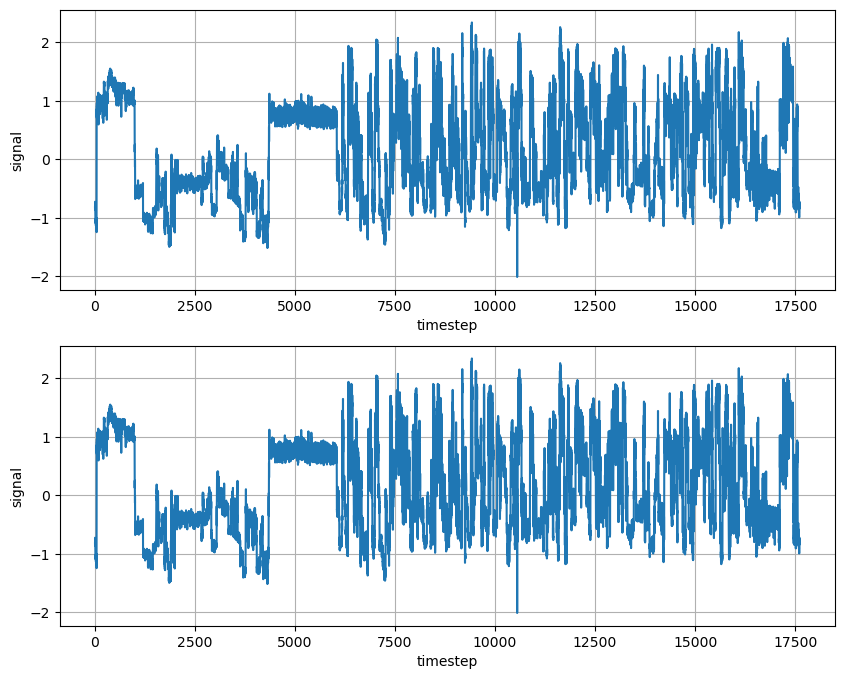

In [119]:
fig, axs= plt.subplots(2, figsize=(10,8), sharex="row", sharey="col")
tsteps = range(len(signal_rodan))
       
# plot signal
axs[0].plot(tsteps, signal_rodan)
axs[1].plot(tsteps, signal_feito)
# ax.set_title(f"signal {i}")
for i in [0,1]:
    axs[i].set_xlabel("timestep")
    axs[i].set_ylabel("signal")
    axs[i].grid(True)

fig_b.suptitle("RODAN and FEITO")    
fig_b.tight_layout()
plt.show()